In [2]:
import os
import requests
import json
import pickle
import yfinance as yf
from bs4 import BeautifulSoup
from lxml import etree
from datetime import datetime
from matplotlib import pyplot as plt
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import datetime
import json
import time

### Gather all the SP500 & financial indicator ticker symbols through Wikipedia

In [4]:
## sp500 stocks 
all_tickers_xpath = "//span[text() = \"S&P 500 component stocks\"]/following::tbody[1]/tr/td[1]/a"
soup = BeautifulSoup(requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").content, 'html.parser')
dom = etree.HTML(str(soup))

# find all tickers
all_tickers = [i.text for i in dom.xpath(all_tickers_xpath)]

# look at the first 5 ticker symbols
print("The first 5 ticker symbols:")
print(all_tickers[:5])

# also gather all financial indicator symbols

"""
    Here are some of the useful Market indices to track:
    
    Gold futures and spot prices are a great way to see how the dollar is 
    changing over a certain period of time, which is reflective of inflation 
    and market sentiment through futures.

    Crude oil prices influence the cost of production and manufacturing across
    the country. Reduction of oil prices directly affect the consumer at a large
    scale, as there is a greater discretionary income available, serving as a
    stimulant for the economy.

    The SP500 index tracks the general trend of the SP500 market. This index
    value is very helpful when trying to predict price movements because it
    is like an estimate of overall market trends.

    Market Volatility Index reflects a volatility measure for the next 30 days.
    "VIX values >= 30 are linked to volatility from uncertainty, risk, and
    investors' fear. VIX values below 20 correspond to stable, stress-free
    period in the markets."

    US Dollar Index measures the value of the US dollar in relation to a
    collection of foreign currencies. The base value of this index is 100
    and values are interpreted relative to that base. (we can standardize)
        if the index is above 100, the dollar is stronger compared to the
        other currencies. otherwise the opposite reflects inverse relation-
        ship.

    Copper is used across technology, energy, and construction. These prices
    will capture a baseline econoimc condition, where rising copper prices
    may indicate inflation or tightening economic conditions.
"""

# Gold Futures
all_tickers.append("GC=F")

# Gold Spot Prices (SPDR GLD tracks the price of the gold bullion OTC market)
all_tickers.append("GLD")

# Crude Oil Futures
all_tickers.append("CL=F")

# SP500 index (relevant to the entire sector)
all_tickers.append("^GSPC")

# Market Volatility Index
all_tickers.append("^VIX")

# US dollar index
all_tickers.append("DX-Y.NYB")

# Copper futures
all_tickers.append("HG=F")

The first 5 ticker symbols:
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


### Gather all stock market data for every ticker symbol on the SP500

In [ ]:
# yfinance is very convenient and allows us to do this in one function call
tickers_df = yf.download(' '.join(all_tickers), group_by='tickers')
tickers_df.to_csv('stock_ticker_data.csv')

[*********************100%***********************]  510 of 510 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-12-26 -> 2024-12-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [ ]:
# some summary statistics for the ticker data
rows_cnt, col_cnt = np.shape(tickers_df)
print('Number of rows:', rows_cnt, 'Number of cols:', col_cnt)

# see the last bit of data for the group ticker symbols
tickers_df.tail()

Number of rows: 24514 Number of cols: 3060


Ticker            CFG                                                     \
Price            Open       High    Low      Close  Adj Close     Volume   
Date                                                                       
2024-11-25  48.040001  49.250000  48.00  48.459999  48.459999  4462400.0   
2024-11-26  48.299999  48.580002  47.98  48.099998  48.099998  2582100.0   
2024-11-27  48.430000  48.750000  47.93  48.160000  48.160000  2120100.0   
2024-11-28        NaN        NaN    NaN        NaN        NaN        NaN   
2024-11-29  48.299999  48.389999  47.57  48.139999  48.139999  1977700.0   

Ticker             URI                                      ...          GWW  \
Price             Open        High         Low       Close  ...          Low   
Date                                                        ...                
2024-11-25  857.809998  873.419983  855.140015  864.390015  ...  1199.680054   
2024-11-26  860.640015  873.989990  852.500000  873.169983  ...  1201.880005   
2024-11-27  878.419983  881.169983  856.190002  856.979980  ...  1203.369995   
2024-11-28         NaN         NaN         NaN         NaN  ...          NaN   
2024-11-29  869.789978  875.150024  862.000000  866.000000  ...  1205.270020   

Ticker                                                HST             \
Price             Close    Adj Close    Volume       Open       High   
Date                                                                   
2024-11-25  1215.760010  1215.760010  457500.0  18.330000  18.570000   
2024-11-26  1217.300049  1217.300049  187100.0  18.320000  18.469999   
2024-11-27  1205.869995  1205.869995  163800.0  18.309999  18.610001   
2024-11-28          NaN          NaN       NaN        NaN        NaN   
2024-11-29  1205.339966  1205.339966  126600.0  18.580000  18.650000   

Ticker                                                   
Price             Low      Close  Adj Close      Volume  
Date                                                     
2024-11-25  18.290001  18.420000  18.420000  13101500.0  
2024-11-26  18.250000  18.309999  18.309999   8026900.0  
2024-11-27  18.309999  18.430000  18.430000   6952100.0  
2024-11-28        NaN        NaN        NaN         NaN  
2024-11-29  18.420000  18.420000  18.420000   4412600.0  

[5 rows x 3060 columns]

### Gathering Congressional trade data

In [ ]:
# ~ 17,000 + 8,000 congressional trading data (pretty useful for all raw data from House)
# we have to transform this data into something useful, will research into that later
# https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json
# https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json

In [7]:
house_trade_data = requests.get("https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json")
senate_trade_data = requests.get("https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json")

In [13]:
# extract all the useful information from congressional trading data
house_json, senate_json = house_trade_data.json(), senate_trade_data.json()
house_df, senate_df = pd.DataFrame(house_json), pd.DataFrame(senate_json)

house_df = house_df[['ticker', 'type', 'amount', 'disclosure_date', 'representative', 'sector', 'party']]
senate_df = senate_df[['ticker', 'type', 'amount', 'disclosure_date', 'senator', 'sector', 'party']]

colnames = ['ticker', 'type', 'amount', 'disclosure_date', 'person', 'sector', 'party']
house_df.columns = colnames
senate_df.columns = colnames

congressional_df = pd.concat([house_df, senate_df])
congressional_df.to_csv('congressional_data.csv')

del house_json, senate_json, house_df, senate_df

### Gathering all required textual data (for sentiment/ market condition embeddings)

In [ ]:
# I am working on 5 years of data for all the tickers given by the SP500.

# literally all reddit data held in the Pushshift api dumps for years up to 2023:
#   you will need Torrent to deal with this data (ill run it on my computer and push data to github)
# https://www.reddit.com/r/pushshift/comments/1akrhg3/separate_dump_files_for_the_top_40k_subreddits/

'''
    We are pulling from these subreddit sources:
        subreddits23/wallstreetbets_submissions.zst	474.51MB
        subreddits23/stocks_submissions.zst	87.74MB
        (these are compressed zstandard file formats)

    the source of data:
    https://academictorrents.com/details/56aa49f9653ba545f48df2e33679f014d2829c10
'''

In [ ]:
'''
    The file is not going to be present here in this repo (since it is very large), but
    the second best way of gathering data would be to specify the filepath for wherever
    it is on your system (for me, its on an external SSD).

    uncompressed:
    r/stocks_submissions is ~800kB
    r/wallstreetbets_submissions is ~6Mb

    most of that data involve posts with URL/ links or images, which isn't that useful
    so there will be a simple heuristic to filter good vs. bad posts.
    
    because it is impractial to load all of this into memory at once, we will read
    the file one line at a time and filter for the desired data.
'''

In [ ]:
def good_post(post_json: dict, from_date: datetime.datetime, min_selftext: int = 10,
              max_selftext: int = 200, min_score: int = 10, min_num_comments: int = 5) -> bool:
    """
        A heuristic applied to determine whether a post is high quality
        or not.
    """
    if not post_json["created_utc"] or type(post_json["created_utc"]) != int:
        if type(post_json["created_utc"]) == str and post_json["created_utc"].isnumeric():
            post_json["created_utc"] = int(post_json["created_utc"])
        elif type(post_json["created_utc"]) == float:
            post_json["created_utc"] = int(post_json["created_utc"])
        else:
            print(type(post_json["created_utc"]), post_json["created_utc"])
            raise Exception("cannot parse created_utc")
    
    post_datetime = datetime.datetime.fromtimestamp(post_json["created_utc"])

    if post_datetime < from_date:
        return False
    
    good_post = min_selftext <= len(post_json["selftext"]) <= max_selftext and \
        post_json["score"] >= min_score and post_json["num_comments"] >= min_num_comments
    
    return good_post

def get_reddit_data(filepath: str, from_date: datetime.datetime, min_selftext: int = 10, 
                    max_selftext: int = 200, min_score: int = 10, min_num_comments: int = 5, 
                    verbose: bool = True, verbose_increment: int = 100_000) -> pd.DataFrame:
    """ 
        Scans through the PushShift API dumps file and extracts only the relevant post data
        for our purposes.
    """

    if verbose:
        print("Getting reddit data for", filepath)

    relevant_attributes = set([
        "title",
        "selftext",
        "num_comments",
        "score",
        "created_utc"
    ])

    saved_posts = []
    with open(filepath, 'r') as f:
        for lines_processed, line in enumerate(f, start=1):
            post_json = json.loads(line)

            if good_post(post_json, from_date, min_selftext, max_selftext, min_score, 
                         min_num_comments):
                saved_posts.append({key: post_json.get(key) for key in post_json.keys() if \
                                    key in relevant_attributes})

            if verbose and lines_processed % verbose_increment == 0:
                print(f"Processed {lines_processed} lines, len(saved_posts) = {len(saved_posts)}")
    
    df = pd.DataFrame(saved_posts)
    df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s").dt.date
    return df


In [203]:
stocks_dir = "D:/Projects/Stock-Predictions/reddit/subreddits23/stocks_submissions"
wsb_dir = "D:/Projects/Stock-Predictions/reddit/subreddits23/wallstreetbets_submissions"
assert os.path.isdir(stocks_dir)
assert os.path.isdir(wsb_dir)

stocks_filepath = os.path.join(stocks_dir, stocks_dir.split('/')[-1])
wsb_filepath = os.path.join(wsb_dir, wsb_dir.split('/')[-1])

assert os.path.isfile(stocks_filepath)
assert os.path.isfile(wsb_filepath)

from_date = datetime.datetime(2015, 1, 1)

# I can use a more restrictive measure for wsb data since there are a lot more posts
#   on that subreddit
stocks_reddit_df = get_reddit_data(stocks_filepath, from_date=from_date, min_num_comments=5, min_score=5, 
                                   verbose=True)
wsb_reddit_df = get_reddit_data(wsb_filepath, from_date=from_date, min_num_comments=10, min_score=20, 
                                verbose=True, verbose_increment=500_000)

Getting reddit data for D:/Projects/Stock-Predictions/reddit/subreddits23/stocks_submissions\stocks_submissions
Processed 100000 lines, len(saved_posts) = 5570
Processed 200000 lines, len(saved_posts) = 7127
Processed 300000 lines, len(saved_posts) = 7138
Getting reddit data for D:/Projects/Stock-Predictions/reddit/subreddits23/wallstreetbets_submissions\wallstreetbets_submissions
Processed 500000 lines, len(saved_posts) = 8285
Processed 1000000 lines, len(saved_posts) = 9517
Processed 1500000 lines, len(saved_posts) = 10128
Processed 2000000 lines, len(saved_posts) = 10336


In [208]:
# there are a lot of posts we can use
sentiment_df = pd.concat([stocks_reddit_df, wsb_reddit_df])

# set a limit for the number of posts per day
max_posts_limit = 40
sentiment_df = sentiment_df.groupby("created_utc").apply(lambda x: x.sample(n=min(len(x), max_posts_limit))).reset_index(drop=True)

print(f"Number of posts: {sentiment_df.shape[0]}")
sentiment_df

Number of posts: 18042


C:\Users\abhin\AppData\Local\Temp\ipykernel_28364\2818931876.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment_df = sentiment_df.groupby("created_utc").apply(lambda x: x.sample(n=min(len(x), max_posts_limit))).reset_index(drop=True)


,title,created_utc,selftext,num_comments,score
0,I want to try to try out the stock market but ...,2015-01-02,- Where is the best site to buy stocks for beg...,22,7
1,2015 Stock Picking Contest,2015-01-04,What's your top stock for 2015 and quick thesi...,44,24
2,Good twitter handles to follow for live stock ...,2015-01-05,"I already follow super_trades, d4ytrad3, and s...",12,13
3,Source for any erotic Charles Schwab fan fiction?,2015-01-05,He really gets me going in that blue shirt and...,12,41
4,Which companies are on your IPO watch list for...,2015-01-07,There are lots of interesting IPOs likely to c...,39,22
...,...,...,...,...,...
18037,Maersk ship hit in the red sea,2023-12-31,https://gcaptain.com/maersk-ship-hit-by-missil...,171,451
18038,"As 2023 comes to an end, what is your expectat...",2023-12-31,"With the market recovering to all time highs, ...",459,248
18039,"I have a $50,000 position in NIO… MOON",2023-12-31,Q4 deliveries get announced tomorrow and based...,93,101
18040,What’s the coolest thing your wife’s boyfriend...,2023-12-31,What’s the 3 coolest things your wife’s boyfri...,103,86


<BarContainer object of 2683 artists>

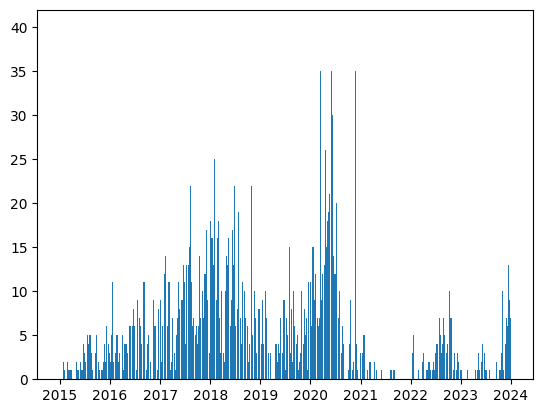

In [209]:
daily_counts = sentiment_df.groupby("created_utc").size()
# some days have 0 data, while others have a ton of data...
plt.bar(x=daily_counts.index, height=daily_counts)

In [210]:
# finally, save the file
sentiment_df.to_csv("sentiment_text.csv")

<h5>Define some functions for technical indicators</h5>

In [7]:
# finanicial indicator functions
# note that these are indented to work with ONE key value
# ex. ONLY DATES means that we must group by stock ticker
# note: TICKERS will not make sense for these functions as keys

def check_series_numeric(column) -> bool:
    not_numeric = column.apply(pd.to_numeric, errors = 'coerce').isna().all()
    # if the data is not numeric, the test failed 
    return not not_numeric

def calculate_sma(column, period = 10):
    if not check_series_numeric(column):
        return column
    sma = column.rolling(period).mean()
    return pd.Series(sma, index= column.index, name = 'SMA')

def calculate_ema(column, period = 10):
    if not check_series_numeric(column):
        return column
    ema = column.ewm(span = period, min_periods = period - 1).mean()
    return pd.Series(ema, index = column.index, name = 'EMA')

def calculate_rsi_helper(column, period = 14, use_exponential = False):
    if not check_series_numeric(column):
        return column 

    column = column.astype(float)
    # find differences in prices
    differences = column.diff() 

    # clip, but center off of zero value
    gain = differences.clip(lower = 0.01)
    loss = differences.clip(upper = -0.01)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if use_exponential:
        # get the exponential weighted mean of the very last element in this current rolling window
        avg_gain = gain.ewm(span = period, min_periods = period - 1).mean().iloc[-1]
        avg_loss = loss.ewm(span = period, min_periods = period - 1).mean().iloc[-1]

    RS = avg_gain / avg_loss 
    RSI = 100 - 100 / (1 - RS)

    return RSI

'''
    let RS = average gain / average loss   
    RSI = 100 - 100 / (1 - RS)

    some things to look out for: 
        - using exponential weighted means on the average
            gains and losses made the RSI value much more
            sensitive and fluctuating more based on price
            changes
        - using simple averages made the RSI value more 
            smoothed out

    keyword argument options:
        - period: type int
        - use_exponential: type bool

'''
def calculate_rsi(column, period, use_exponential):
    rsi = column.rolling(14).apply(lambda x: calculate_rsi_helper(x, period=period, use_exponential=use_exponential)).astype(float)
    return pd.Series(rsi, index = column.index, name = 'RSI')

'''
    MACD (moving average convergence/ divergence) shows the relationship
    between two exponential moving averages and comparing this to the 
    9-day EMA line 

    MACD = 12-period EMA - 26-period EMA 
    Signal = 9-period EMA - 26-period EMA
'''
def calculate_macd(column, long_period = 26, short_period = 12, signal_period = 9) -> tuple[object, object]:
    if not check_series_numeric(column):
        return column 
    
    # Calculate the short and long EMAs
    ewm_short = column.ewm(span=short_period, min_periods=short_period-1).mean()
    ewm_long = column.ewm(span=long_period, min_periods=long_period-1).mean()

    # Calculate MACD line
    macd = (ewm_short - ewm_long).astype(float)

    # Calculate the Signal line (EMA of MACD)
    ewm_signal = macd.ewm(span=signal_period, min_periods=signal_period-1).mean()
    signal = ewm_signal.astype(float)

    # Return both MACD and Signal as pandas Series
    macd = pd.Series(macd, index=column.index, name='MACD')
    signal = pd.Series(signal, index=column.index, name='MACD-SIGNAL')

    return macd, signal

"""
    Calculate the average stock price between 30 and 45 days after the present day.
    Expects that data is given in sorted order by date.

    - data: pd.DataFrame with stock data indexed by date.
    - column_name: str, the column name containing the stock prices.
    This returns the average stock price between 30 and 45 days after the present day.
"""
def calculate_future_average_stock_price(column):
    # Initialize a new series to store the future averages
    future_averages = []

    # Iterate over the series to calculate the future average for each index
    for i in range(len(column)):
        # The future range is from i+30 to i+45 (exclusive of 45)
        future_values = column.iloc[i+30:i+45]
        future_price = future_values.mean() if len(future_values) > 0 else None
        percent_change = future_price / column.iloc[i] if future_price is not None else None
        future_averages.append(percent_change)
    
    # Return the result as a new series
    return pd.Series(future_averages, index=column.index, name="FutureAverage")

### Load dataframe objects here and avoid running all the pipeline above

In [8]:
# load all the dataframe objects
if "tickers_df" not in dir():
    tickers_df = pd.read_csv("stock_ticker_data.csv", header=[0,1])

if "congressional_df" not in dir():
    congressional_df = pd.read_csv("congressional_data.csv")

if "sentiment_df" not in dir():
    sentiment_df = pd.read_csv("sentiment_text.csv")

### Prepare dataset to predict AAPL (Apple) price movements

In [9]:
""" 
    Data cleaning and feature engineering the tickers dataframe:
        - I only ned to know Adj Close and Volume numbers for relevant metrics per each stock
        - The stocks of interest are:
            - Stock that I am predicting for trading
            - Probably some other related stocks (2-6 of them)
            - Global market conditions indicators
"""

# a little before and ahead of datetime to ensure tech indicators cover full range
start_date = datetime.datetime(2010, 12, 1)
end_date = datetime.datetime(2023, 2, 1)

prediction_ticker = ["Ticker", "AAPL"]
relevant_tickers = ["MSFT", "AMZN", "GOOGL", "META", "NVDA"]
global_market_tickers = ["GC=F", "GLD", "CL=F", "^GSPC", "^VIX", "DX-Y.NYB", "HG=F"]
apple_prediction_tickers = prediction_ticker + relevant_tickers + global_market_tickers
apple_df = tickers_df[apple_prediction_tickers]
cols_to_keep = set(["Adj Close", "Volume"])
remapped_columns = [f"{outer}:{inner}" for outer, inner in apple_df.columns]
apple_cols_to_keep = ["Ticker:Price"] + [f"{outer}:{inner}" for outer, inner in apple_df.columns if inner in cols_to_keep]
apple_df.columns = remapped_columns
apple_df = apple_df[apple_cols_to_keep]
apple_df = apple_df.iloc[1:]
apple_df["Ticker:Price"] = pd.to_datetime(apple_df["Ticker:Price"])
apple_df = apple_df[(apple_df["Ticker:Price"] >= start_date) & (apple_df["Ticker:Price"] <= end_date)]
apple_df = apple_df.set_index("Ticker:Price").rename_axis("Date")


nrow, ncol = apple_df.shape
print("nrow", nrow, "ncol", ncol)
print("After some cleanup, here is the AAPL technical indicator dataframe:")
print()
apple_df.head()

nrow 3064 ncol 26
After some cleanup, here is the AAPL technical indicator dataframe:



,AAPL:Adj Close,AAPL:Volume,MSFT:Adj Close,MSFT:Volume,AMZN:Adj Close,AMZN:Volume,GOOGL:Adj Close,GOOGL:Volume,META:Adj Close,META:Volume,...,CL=F:Adj Close,CL=F:Volume,^GSPC:Adj Close,^GSPC:Volume,^VIX:Adj Close,^VIX:Volume,DX-Y.NYB:Adj Close,DX-Y.NYB:Volume,HG=F:Adj Close,HG=F:Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-01,9.532084,461750800.0,20.012495,74123500.0,8.8275,115402000.0,14.087989,150013836.0,NaN,NaN,...,86.750000,340736.0,1206.069946,4.548110e+09,21.360001,0.0,80.709999,0.0,3.946,1301.0
2010-12-02,9.584808,462837200.0,20.665745,91759200.0,8.8265,110752000.0,14.274464,101814084.0,NaN,NaN,...,88.000000,330642.0,1221.530029,4.970800e+09,19.389999,0.0,80.300003,0.0,3.977,907.0
2010-12-03,9.563414,342092800.0,20.765650,52622000.0,8.7840,98150000.0,14.303920,105142752.0,NaN,NaN,...,89.190002,354635.0,1224.709961,3.735780e+09,18.010000,0.0,79.379997,0.0,3.995,543.0
2010-12-06,9.645058,448481600.0,20.627316,36264200.0,8.9025,113084000.0,14.437722,83668248.0,NaN,NaN,...,89.379997,293836.0,1223.119995,3.527370e+09,18.020000,0.0,79.570000,0.0,4.004,377.0
2010-12-07,9.586614,391454000.0,20.650375,57860500.0,8.8385,101542000.0,14.656900,121566312.0,NaN,NaN,...,88.690002,462689.0,1223.750000,6.970630e+09,17.990000,0.0,79.860001,0.0,4.044,1155.0


### Applying all technical indicator data on AAPL data

In [10]:
short_period = 15
long_period = 30

# get the Y value: future average stock price
apple_df["future_avg_price"] = calculate_future_average_stock_price(apple_df["AAPL:Adj Close"])
cols = apple_df.columns
for colname in cols:
    print(colname)
    if "Volume" in colname:
        # get the ewn of volumes
        apple_df[colname + "_ewm_short"] = apple_df[colname].ewm(span=short_period, adjust=False).mean()
        apple_df[colname + "_ewm_long"] = apple_df[colname].ewm(span=short_period, adjust=False).mean()
    elif "Adj Close" in colname:
        # get RSI & MACD signal difference otherwise
        apple_df[colname + "_rsi"] = calculate_rsi(apple_df[colname], period=14, use_exponential=True)
        macd, signal = calculate_macd(apple_df[colname])
        apple_df[colname + "_macd_diff"] = macd - signal

    # apple_df.drop(colname, inplace=True)

AAPL:Adj Close
AAPL:Volume
MSFT:Adj Close
MSFT:Volume
AMZN:Adj Close
AMZN:Volume
GOOGL:Adj Close
GOOGL:Volume
META:Adj Close
META:Volume
NVDA:Adj Close
NVDA:Volume
GC=F:Adj Close
GC=F:Volume
GLD:Adj Close
GLD:Volume
CL=F:Adj Close
CL=F:Volume
^GSPC:Adj Close
^GSPC:Volume
^VIX:Adj Close
^VIX:Volume
DX-Y.NYB:Adj Close
DX-Y.NYB:Volume
HG=F:Adj Close
HG=F:Volume
future_avg_price


In [20]:
keep_cols = [colname for colname in apple_df.columns if "_" in colname and "VIX:Volume" not in colname]
apple_df = apple_df[keep_cols]
apple_df

,future_avg_price,AAPL:Adj Close_rsi,AAPL:Adj Close_macd_diff,AAPL:Volume_ewm_short,AAPL:Volume_ewm_long,MSFT:Adj Close_rsi,MSFT:Adj Close_macd_diff,MSFT:Volume_ewm_short,MSFT:Volume_ewm_long,AMZN:Adj Close_rsi,...,^VIX:Adj Close_rsi,^VIX:Adj Close_macd_diff,DX-Y.NYB:Adj Close_rsi,DX-Y.NYB:Adj Close_macd_diff,DX-Y.NYB:Volume_ewm_short,DX-Y.NYB:Volume_ewm_long,HG=F:Adj Close_rsi,HG=F:Adj Close_macd_diff,HG=F:Volume_ewm_short,HG=F:Volume_ewm_long
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-01,1.076100,NaN,NaN,4.617508e+08,4.617508e+08,NaN,NaN,7.412350e+07,7.412350e+07,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1301.000000,1301.000000
2010-12-02,1.070352,NaN,NaN,4.618866e+08,4.618866e+08,NaN,NaN,7.632796e+07,7.632796e+07,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1251.750000,1251.750000
2010-12-03,1.073461,NaN,NaN,4.469124e+08,4.469124e+08,NaN,NaN,7.336472e+07,7.336472e+07,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1163.156250,1163.156250
2010-12-06,1.067404,NaN,NaN,4.471085e+08,4.471085e+08,NaN,NaN,6.872715e+07,6.872715e+07,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1064.886719,1064.886719
2010-12-07,1.077959,NaN,NaN,4.401517e+08,4.401517e+08,NaN,NaN,6.736882e+07,6.736882e+07,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1076.150879,1076.150879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,NaN,89.877302,1.789046,6.982556e+07,6.982556e+07,76.000267,1.601311,3.556511e+07,3.556511e+07,73.782786,...,33.233512,-0.098545,29.519546,-0.012555,4.098580e-111,4.098580e-111,69.252497,0.010237,542.032099,542.032099
2023-01-27,NaN,91.689990,1.840992,6.991684e+07,6.991684e+07,75.746952,1.771554,3.443183e+07,3.443183e+07,79.809506,...,28.460427,-0.112199,37.387755,0.014579,3.586258e-111,3.586258e-111,54.738372,0.003587,548.778087,548.778087
2023-01-30,NaN,68.518800,1.590925,6.917915e+07,6.917915e+07,56.930984,1.447532,3.336128e+07,3.336128e+07,67.792477,...,55.450122,-0.016884,50.946210,0.060868,3.137975e-111,3.137975e-111,50.239994,-0.003125,538.680826,538.680826


In [ ]:
# i have to remap exponential moving averages to percent changes so that we can normalize that properly still but then we done finally.